# 3. Fine-tuning a Sentiment Analysis model with a custom dataset

This notebook shows us how to fine-tune a sentiment analysis model not only on a HuggingFace dataset, but on any dataset we may have.

In [58]:
!pip install --q transformers torch datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [60]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [61]:
df_ = pd.read_csv('AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [62]:
df = df_[['airline_sentiment', 'text']].copy() # Select only the cols we need
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

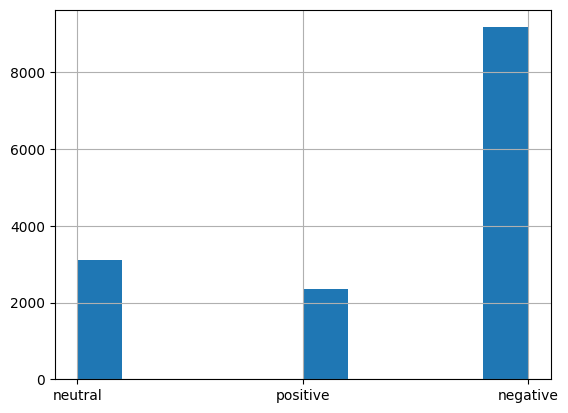

In [63]:
df['airline_sentiment'].hist()

**Note** we have an imbalanced dataset, let's see if our model can handle this.

In [64]:
# Map labels to ints, required for NNs
target_map = {'positive': 1,'negative':0, 'neutral':2}
df['target'] = df['airline_sentiment'].map(target_map)

In [65]:
# Save to a CSV file
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label'] # This renaming is needed, specially the labels one
df2.to_csv('data_sentiment_finetuning.csv', index=None)

!head data_sentiment_finetuning.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [66]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data_sentiment_finetuning.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [67]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [68]:
# Split our data into train and test sets
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [69]:
checkpoint = 'distilbert-base-cased'

In [70]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [71]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [72]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [73]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
!pip install torchinfo
from torchinfo import summary
summary(model)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

**Note** that our model has almost 66M parameters, all of them trainable.

Now, let's create our model trainable object:

In [76]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

Now let's define our compute metrics function. In the past notebook we used pre-loaded metrics corresponding to the dataset we were using, but now we don't have these. However, we'll use the same approach: compute a dictionary with metrics names as keys together with their value.

In [77]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

Now, we'll build our trainer object and begin the training process:

In [78]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.556300,0.451642,0.827869,0.762072
2,0.352700,0.489575,0.840164,0.778512
3,0.251900,0.608796,0.840847,0.789447


TrainOutput(global_step=1923, training_loss=0.3368777127794096, metrics={'train_runtime': 189.0831, 'train_samples_per_second': 162.595, 'train_steps_per_second': 10.17, 'total_flos': 388879472366064.0, 'train_loss': 0.3368777127794096, 'epoch': 3.0})

Our model seems to overfit on the third epoch (validation loss becomes considerably -3x- bigger than our training loss). However, we don't need to start from scratch, since the model is save at the end of each epoch, we can simply take the best model from one of the intermediate steps. Let's get the one from the second epoch (the one with the highest validation performance).

In [79]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Let's instintiate a pipeline on our winner model and make some predictions on the test set with it. Ofc in the real world this should be a hold-out dataset.

In [81]:
from transformers import pipeline

savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

In [82]:
split['test']

test_pred = savedmodel(split['test']['sentence'])
test_pred

[{'label': 'LABEL_1', 'score': 0.9480838775634766},
 {'label': 'LABEL_1', 'score': 0.9514332413673401},
 {'label': 'LABEL_0', 'score': 0.4951448142528534},
 {'label': 'LABEL_1', 'score': 0.8773415088653564},
 {'label': 'LABEL_0', 'score': 0.4805518388748169},
 {'label': 'LABEL_0', 'score': 0.996890127658844},
 {'label': 'LABEL_2', 'score': 0.6709664463996887},
 {'label': 'LABEL_0', 'score': 0.8956648707389832},
 {'label': 'LABEL_1', 'score': 0.7575122714042664},
 {'label': 'LABEL_0', 'score': 0.9973117113113403},
 {'label': 'LABEL_0', 'score': 0.9869374632835388},
 {'label': 'LABEL_0', 'score': 0.9955541491508484},
 {'label': 'LABEL_1', 'score': 0.9593434929847717},
 {'label': 'LABEL_0', 'score': 0.9943445920944214},
 {'label': 'LABEL_2', 'score': 0.9837385416030884},
 {'label': 'LABEL_0', 'score': 0.5851230621337891},
 {'label': 'LABEL_0', 'score': 0.9120439291000366},
 {'label': 'LABEL_0', 'score': 0.9976512789726257},
 {'label': 'LABEL_0', 'score': 0.9647442102432251},
 {'label': 'L

In [85]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8401639344262295


In [86]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.778511665833966


Now let's plot the confusion matrix for our trained model on the test set. As we have an imbalanced dataset, we want to see if it's working better on one class compared to the other.

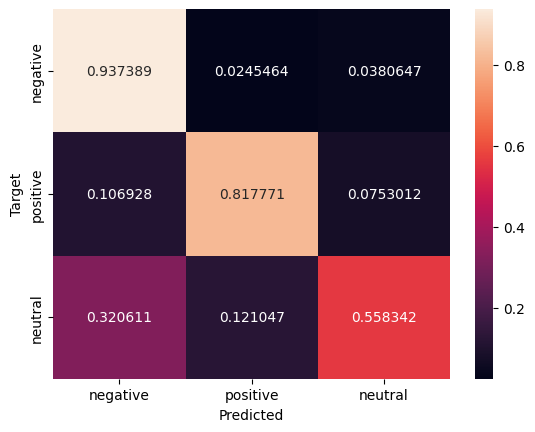

In [87]:
def plot_cm(cm):
    classes = ['negative', 'positive', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)

F1 score < Accuracy, so there seems to be some imbalance in terms of how our model works with each class. E.g. We do very well when predicting the negative sentiment tweets, but not that well when the sentiment is neutral.